In [1]:
import tensorflow as tf

from tensorflow.keras.layers import Input, SimpleRNN, GRU, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

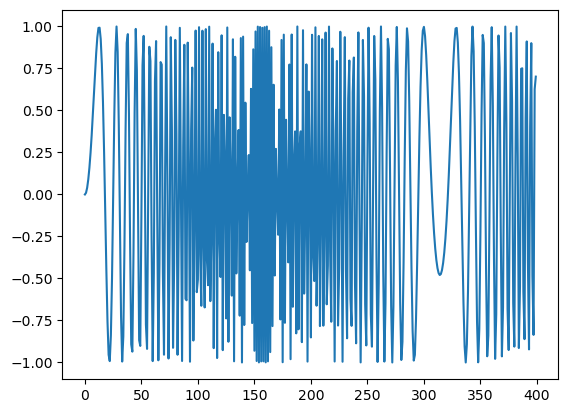

In [2]:
# x(t) = sin(omega * t^2)
# variable frequency & period
series = np.sin((0.1 * np.arange(400)) ** 2) 

plt.plot(series)
plt.show()

### Build dataset


In [4]:
T = 10
D = 1 # x-value
X = []
Y = []

# create steps of 0-9, 1-10 ... 390-399
for t in range(len(series) - T):
    x = series[t: t + T]
    y = series[t + T]
    
    X.append(x)
    Y.append(y)
    
X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print(f"X.shape: {X.shape} | Y.shape: {Y.shape}")

train_data, train_label = X[:-N//2], Y[:-N//2] # first half of data
valid_data, valid_label = X[-N//2:], Y[-N//2:]

X.shape: (390, 10) | Y.shape: (390,)


### 1) Auto-regressive Linear Model


In [11]:
output_node = 1 # 1 means only perform single prediction
num_epochs=100

input = Input(shape=(T,))
x = Dense(output_node)(input)

autoreg_model = Model(input, x)
autoreg_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
)

autoreg_result = autoreg_model.fit(
    train_data, train_label,
    epochs=num_epochs,
    validation_data=(valid_data, valid_label)
)

Epoch 1/100
7/7 [==============================] - 0s 6ms/step - loss: 1.7692 - val_loss: 1.0757
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 1.4859 - val_loss: 0.9580
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 1.2754 - val_loss: 0.8643
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 1.1120 - val_loss: 0.7875
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 0.9637 - val_loss: 0.7204
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 0.8629 - val_loss: 0.6716
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7770 - val_loss: 0.6292
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 0.7066 - val_loss: 0.6026
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6560 - val_loss: 0.5753
Epoch 10/100
7/7 [==============================] - 0s 2ms/step - loss: 0.6142 - val_loss: 0.5566
Epoch 11/100
7/7 [===========

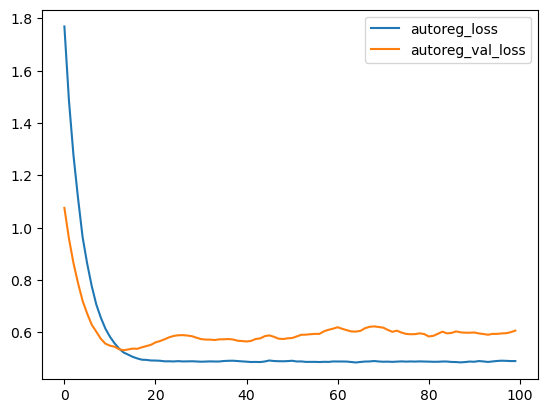

In [12]:
plt.plot(autoreg_result.history['loss'], label='autoreg_loss')
plt.plot(autoreg_result.history['val_loss'], label='autoreg_val_loss')
plt.legend()

### Autoreg model Prediction


13/13 [==============================] - 0s 404us/step


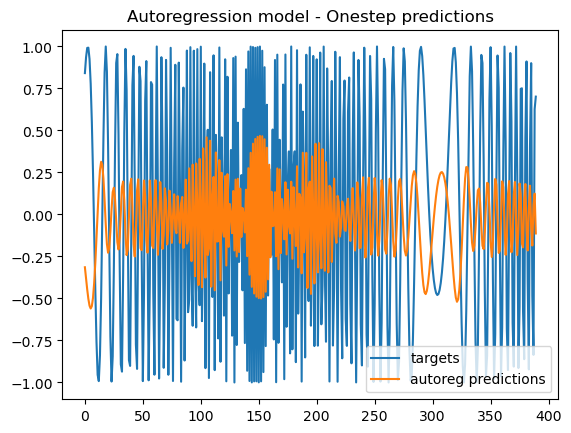

In [14]:
# 1-step forecast (wrong way of performing forecasting because doesn't use predicted values as input)
autoreg_outputs = autoreg_model.predict(X)
autoreg_predictions = autoreg_outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(autoreg_predictions, label='autoreg predictions')
plt.title('Autoregression model - Onestep predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 6ms/step


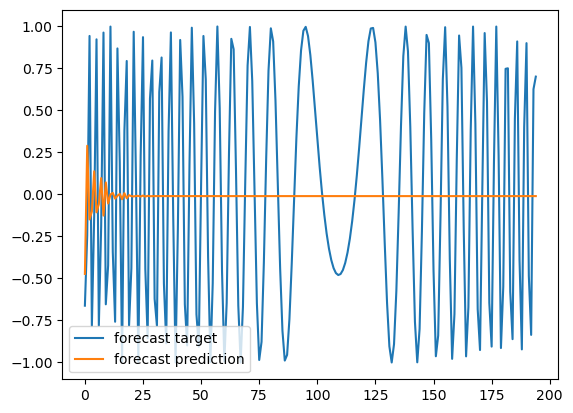

In [15]:
# Multi-step forecast (correct way of performing forecasting)
validation_predictions = []

# X = [[0-9], [1-10]..]
prev_x = X[-N//2] # first x_window of validation set eg: [0: 9]

while len(validation_predictions) < len(valid_label):
    p = autoreg_model.predict(prev_x.reshape(1, -1))[0, 0]
    
    validation_predictions.append(p)
    
    prev_x = np.roll(prev_x, -1) # shift leftwards
    prev_x[-1] = p # append prediction to prev_x

plt.plot(valid_label, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

#### Auto-reg linear model performs poorly in predicting non-linear sequence


### 2 Simple RNN model


In [21]:
rnn_X = X.reshape(-1, T, 1)
print(f"original X: {X.shape} | rnn X: {rnn_X.shape} (N x T x D)")

rnn_train_data = X[:-N//2]
rnn_valid_data = X[-N//2:]

original X: (390, 10) | rnn X: (390, 10, 1) (N x T x D)


In [22]:
hidden_nodes = 10
output_node = 1

input = Input(shape=(T, D))
x = SimpleRNN(hidden_nodes)(input)
x = Dense(output_node)(x)

simple_rnn_model = Model(input, x)
simple_rnn_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
)

simple_rnn_result = simple_rnn_model.fit(
    rnn_train_data, train_label,
    batch_size=32,
    epochs=200,
    validation_data=(rnn_valid_data, valid_label)
)

Epoch 1/200
7/7 [==============================] - 0s 12ms/step - loss: 0.7161 - val_loss: 0.5070
Epoch 2/200
7/7 [==============================] - 0s 2ms/step - loss: 0.5444 - val_loss: 0.5078
Epoch 3/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4912 - val_loss: 0.5180
Epoch 4/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4608 - val_loss: 0.5609
Epoch 5/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4471 - val_loss: 0.5623
Epoch 6/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4284 - val_loss: 0.5587
Epoch 7/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4204 - val_loss: 0.5572
Epoch 8/200
7/7 [==============================] - 0s 2ms/step - loss: 0.4038 - val_loss: 0.5084
Epoch 9/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3907 - val_loss: 0.4862
Epoch 10/200
7/7 [==============================] - 0s 2ms/step - loss: 0.3862 - val_loss: 0.4929
Epoch 11/200
7/7 [==========

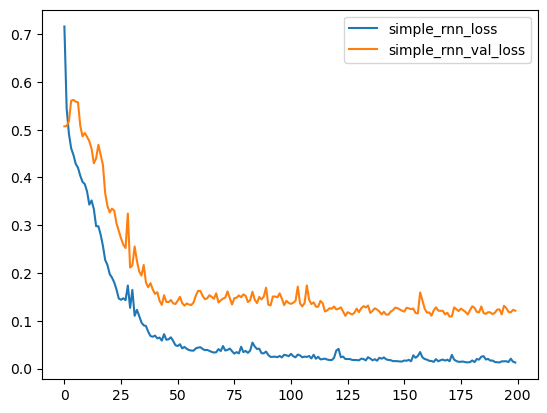

In [24]:
plt.plot(simple_rnn_result.history['loss'], label='simple_rnn_loss')
plt.plot(simple_rnn_result.history['val_loss'], label='simple_rnn_val_loss')
plt.legend()
plt.show()


### Simple RNN model prediction


13/13 [==============================] - 0s 501us/step


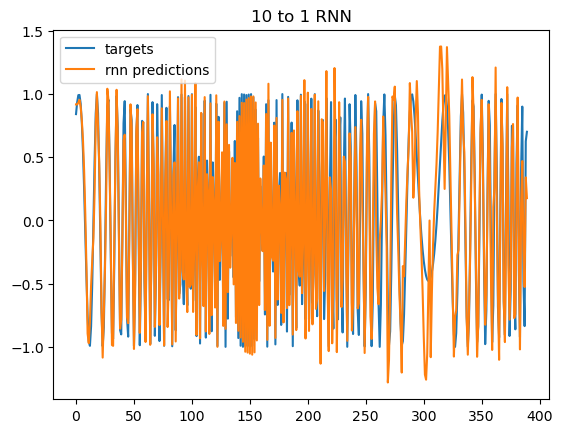

In [25]:
# 1-step forecast

rnn_outputs = simple_rnn_model.predict(rnn_X)
rnn_predictions = rnn_outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(rnn_predictions, label='rnn predictions')
plt.title(f'{hidden_nodes} to {output_node} RNN')
plt.legend()
plt.show()

1/1 [==============================] - 0s 6ms/step


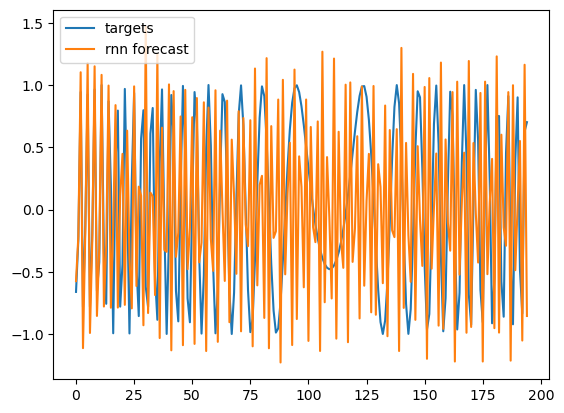

In [26]:
# Multi-step forecast
rnn_forecast = []
prev_input = rnn_X[-N//2] # first window of rnn_X data eg: [0-9]

while len(rnn_forecast) < len(valid_label):
    f = simple_rnn_model.predict(prev_input.reshape(1, T, 1))[0, 0]
    rnn_forecast.append(f)
    
    # update prev_input with latest pred
    prev_input = np.roll(prev_input, -1)
    prev_input[-1] = f

plt.plot(valid_label, label='targets')
plt.plot(rnn_forecast, label='rnn forecast')
plt.legend()
plt.show()

#### Not able to predict the reduced frequency in the second portion

- model trained with only first half of data (increased frequency)
- performs better than auto-regressive linear model


### 3 LSTM Model


In [27]:
hidden_nodes = 10
output_node = 1

input = Input(shape=(T, D))
x = LSTM(hidden_nodes)(input)
x = Dense(output_node)(x)

lstm_model = Model(input, x)
lstm_model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
)

lstm_result = lstm_model.fit(
    rnn_train_data, train_label,
    batch_size=32,
    epochs=200,
    validation_data=(rnn_valid_data, valid_label)
)

Epoch 1/200
7/7 [==============================] - 1s 27ms/step - loss: 0.5855 - val_loss: 0.4611
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5341 - val_loss: 0.4628
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5145 - val_loss: 0.4771
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5013 - val_loss: 0.4978
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4874 - val_loss: 0.5227
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4776 - val_loss: 0.5407
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4591 - val_loss: 0.5694
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4559 - val_loss: 0.5749
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4346 - val_loss: 0.5385
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 0.4224 - val_loss: 0.5261
Epoch 11/200
7/7 [==========

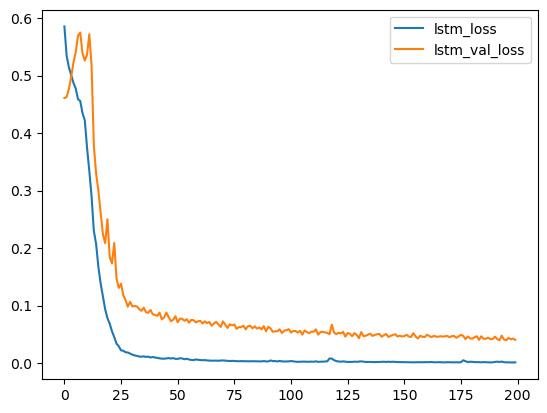

In [28]:
plt.plot(lstm_result.history['loss'], label='lstm_loss')
plt.plot(lstm_result.history['val_loss'], label='lstm_val_loss')
plt.legend()

13/13 [==============================] - 0s 474us/step


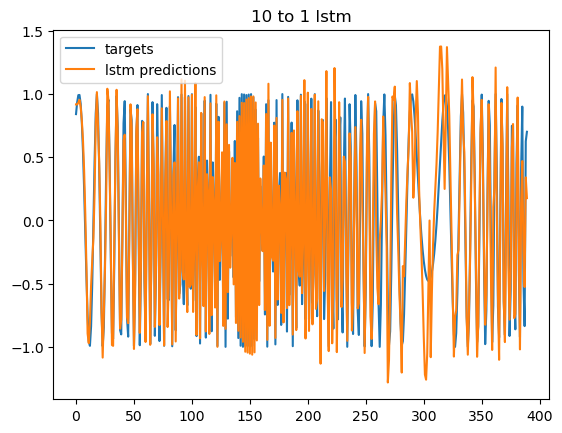

In [30]:
# 1-step forecast (LSTM)

lstm_outputs = lstm_model.predict(rnn_X)
lstm_predictions = rnn_outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(lstm_predictions, label='lstm predictions')
plt.title(f'{hidden_nodes} to {output_node} lstm')
plt.legend()
plt.show()

1/1 [==============================] - 0s 8ms/step


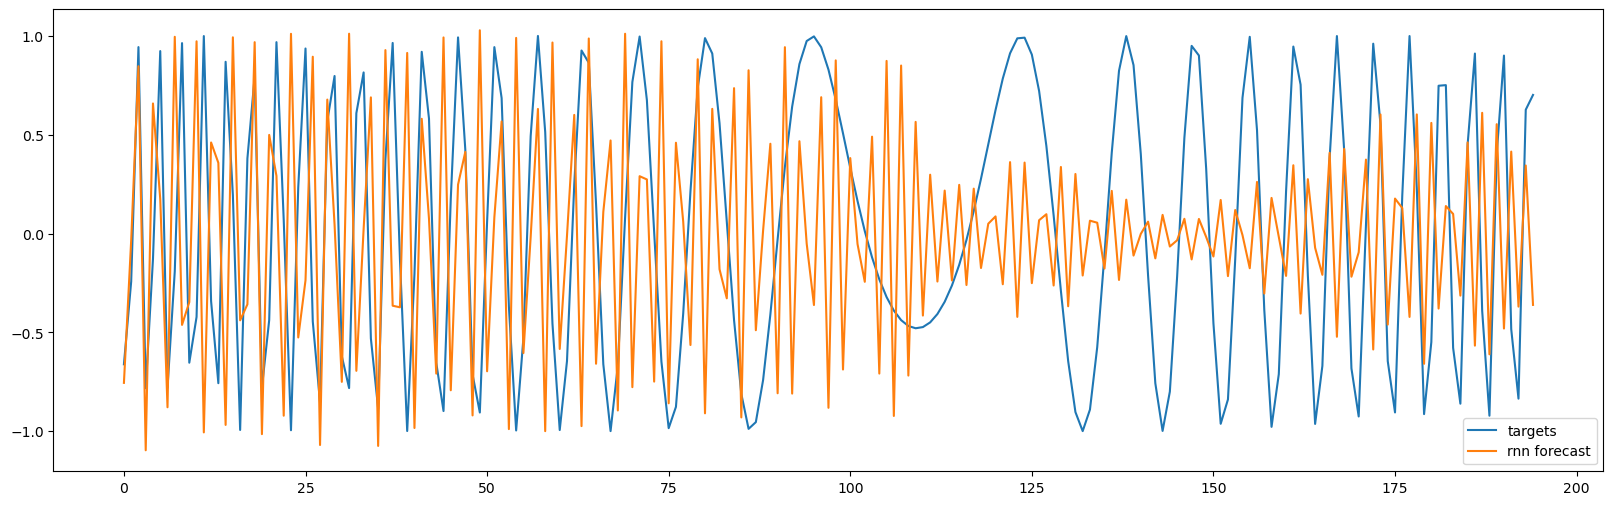

In [ ]:
# Multi-step forecast (lm)
lstm_forecast = []
prev_input = rnn_X[-N//2] # first window of rnn_X data eg: [0-9]

while len(lstm_forecast) < len(valid_label):
    f = lstm_model.predict(prev_input.reshape(1, T, 1))[0, 0]
    lstm_forecast.append(f)
    
    # update prev_input with latest pred
    prev_input = np.roll(prev_input, -1)
    prev_input[-1] = f

plt.figure(figsize=(20,6))
plt.plot(valid_label, label='targets')
plt.plot(lstm_forecast, label='lstm forecast')
plt.legend()
plt.show()

### Discovery

- LSTM are better than RNNs at long term discovery but not better at everything
- As seen above, LSTM is not able to capture the variable frequency sequence
- If sequence is arbitrarily long, LSTM would also forget at some point
- Data early on here does not help in predicting pattern later on, thus no real advantage in using LSTM


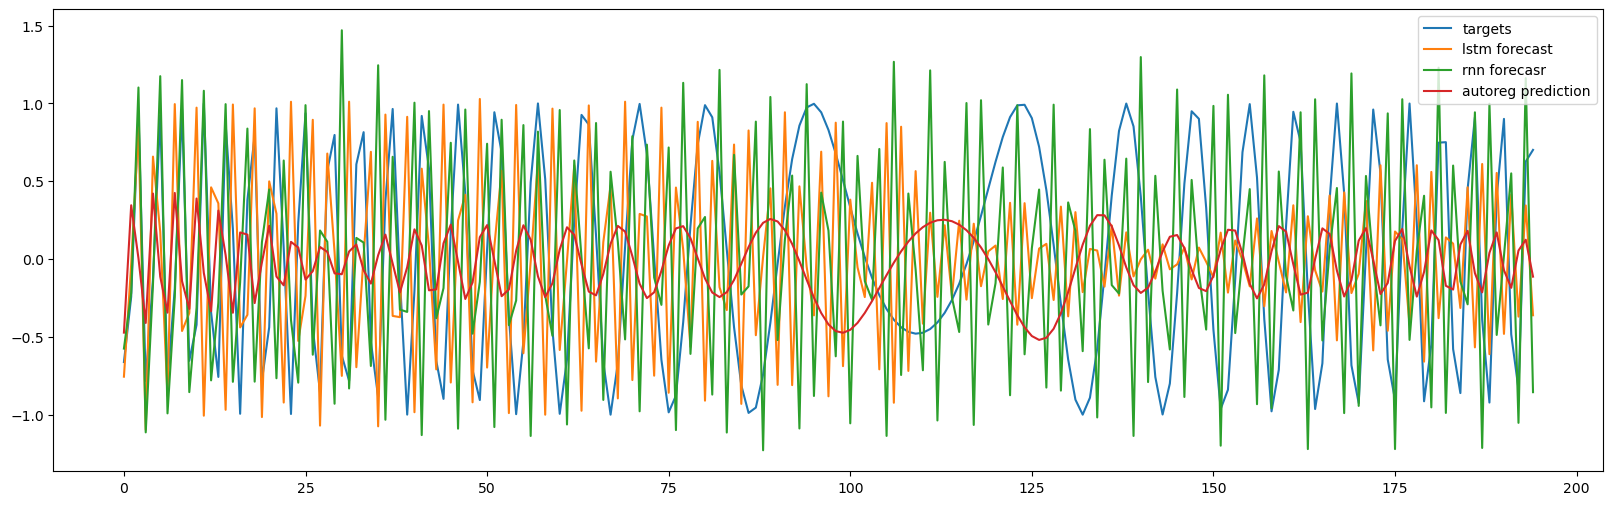

In [46]:
plt.figure(figsize=(20,6))
plt.plot(valid_label, label='targets')
plt.plot(lstm_forecast, label='lstm forecast')
plt.plot(rnn_forecast, label='rnn forecasr')
plt.plot(autoreg_predictions[-N//2:], label='autoreg prediction')
plt.legend()
plt.show()